In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing

import json

import lightgbm as lgb

from lightgbm import plot_importance, plot_tree

try:
    # To enable interactive mode you should install ipywidgets
    # https://github.com/jupyter-widgets/ipywidgets
    from ipywidgets import interact, SelectMultiple
    INTERACTIVE = True
except ImportError:
    INTERACTIVE = False
    
from decouple import config

plt.style.use(config('plot_style'))

## Data Prepare

In [2]:
df_weather = pd.read_csv('data/shenzhen_weather.csv', header=0, sep=',', parse_dates=[0])
df_weather.set_index(['date'], inplace=True)

df_weather

,high_temp,low_temp,is_sunshine,is_rain,is_cloudy
date,,,,,
2019-07-10,29,26,0.0,1.0,0.0
2019-07-11,30,27,0.0,0.0,1.0
2019-07-12,32,28,0.0,0.0,1.0
2019-07-13,31,28,0.0,0.0,1.0
2019-07-14,31,28,0.0,1.0,0.0
...,...,...,...,...,...
2019-09-26,30,24,0.0,0.0,1.0
2019-09-27,31,24,0.0,0.0,1.0
2019-09-28,32,24,0.0,0.0,1.0


In [3]:
df = pd.read_csv('data/timeseries_raw.csv', header=None, sep=',', parse_dates=[0])
df.rename(columns={0:"date"}, inplace=True)
df.set_index(['date'], inplace=True)

df = df[~df.index.isnull()]

df.head()

,1,2,3,4,5,6,7,8,9,10,...,1595,1596,1597,1598,1599,1600,1601,1602,1603,1604
date,,,,,,,,,,,,,,,,,,,,,
2019-07-10,14.0,630.7,2074.9,1305.5,3629.0,993.5,1119.5,915.1,1118.0,3123.7,...,1575.6,561.1,1024.2,1156.1,907.8,604.6,1793.7,3159.7,1972.5,617.5
2019-07-11,18.0,764.3,1057.9,596.8,1368.8,816.2,1303.8,642.2,1004.6,2832.2,...,1482.1,573.5,1446.8,1564.6,925.8,774.0,1553.0,2983.9,1337.3,490.5
2019-07-12,22.4,673.7,1278.2,1055.9,1436.6,1186.3,2160.9,936.2,735.9,3013.7,...,1290.2,625.8,1187.5,1417.7,1048.2,756.3,2257.3,3241.3,2014.8,743.0
2019-07-13,28.5,701.3,1975.9,905.2,1222.7,501.7,1363.5,1476.7,1173.3,1868.3,...,385.1,533.9,1104.4,1170.9,635.1,1159.0,2245.7,1940.7,2256.5,497.5
2019-07-14,25.0,737.5,1641.7,1122.0,1139.1,81.3,1159.0,832.7,1104.4,1356.0,...,309.0,601.7,1287.2,735.2,645.8,945.4,1457.2,1482.5,1930.7,816.0


In [4]:
df.describe()

,1,2,3,4,5,6,7,8,9,10,...,1595,1596,1597,1598,1599,1600,1601,1602,1603,1604
count,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,...,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000
mean,19.637349,692.495181,1641.137349,864.254217,810.632530,972.704819,1310.869880,804.444578,892.227711,2624.044578,...,1130.053012,605.861446,1152.798795,1178.003614,834.840964,805.828916,1505.793976,2684.697590,1809.154217,885.902410
std,35.680612,191.749675,1485.136112,394.821665,396.536111,1191.103670,451.446994,285.318128,248.808727,754.505306,...,525.753913,183.160582,297.743419,270.961678,738.020214,206.993632,435.850325,897.368377,777.581130,254.758516
min,0.000000,370.200000,690.900000,499.200000,388.300000,0.000000,584.800000,345.000000,474.300000,1109.000000,...,0.000000,239.800000,622.500000,735.200000,257.100000,494.800000,651.100000,1169.500000,808.700000,416.500000
25%,0.000000,558.000000,1071.800000,691.600000,601.150000,462.150000,1036.550000,605.600000,710.450000,1983.100000,...,605.950000,497.850000,946.950000,1013.850000,597.450000,675.300000,1211.500000,2011.250000,1334.000000,738.000000
50%,7.200000,682.700000,1324.500000,774.000000,749.100000,949.000000,1178.800000,765.500000,836.700000,2739.400000,...,1296.300000,583.300000,1103.100000,1143.000000,691.700000,765.900000,1457.200000,2800.800000,1692.500000,848.000000
75%,22.600000,784.700000,1617.850000,944.300000,905.350000,1082.600000,1539.900000,939.450000,1035.650000,3042.650000,...,1512.500000,703.850000,1297.600000,1292.750000,897.600000,923.750000,1826.200000,3091.400000,2080.950000,970.000000
max,174.100000,1471.800000,12374.600000,3928.200000,3629.000000,10397.500000,2993.000000,2037.800000,1664.700000,6085.400000,...,2017.600000,1128.400000,2344.700000,2086.200000,6458.800000,1808.000000,2772.800000,6798.000000,5940.300000,1857.400000


In [5]:
# 2019-07-10 00:00:00 to 2019-10-09 23:59:59

DATETIME_START_OF_TRAIN = config('DATETIME_START_OF_TRAIN')
DATETIME_END_OF_TRAIN = config('DATETIME_END_OF_TRAIN')
DATETIME_START_OF_TEST = config('DATETIME_START_OF_TEST')
DATETIME_END_OF_TEST = config('DATETIME_END_OF_TEST')
DATETIME_START_OF_PREDICT = config('DATETIME_START_OF_PREDICT')
DATETIME_END_OF_PREDICT = config('DATETIME_END_OF_PREDICT')

# we use 1 day frequency for the time series
freq = config('freq')

# we predict for 7 days
prediction_length = config('prediction_length', cast=int)

# we also use 14 days as context length, this is the number of state updates accomplished before making predictions
context_length = config('context_length', cast=int)

sample_sites = config('sample_sites', cast=lambda v: [int(s.strip()) for s in v.split(',')])

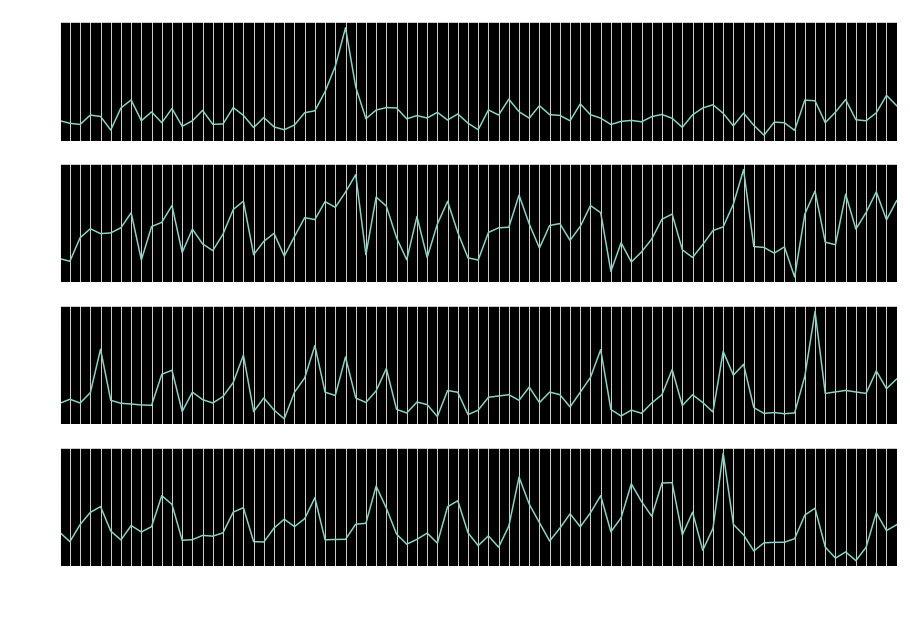

In [6]:
fig, axs = plt.subplots(len(sample_sites), 1, figsize=(15, 10), sharex=True)
axx = axs.ravel()
for i, site in enumerate(sample_sites):
    _ = df.loc[:, site].plot(ax=axx[i], style='-', title=f"site: {site}")
    axx[i].set_xlabel("date")    
    axx[i].set_ylabel("sales RMB")   
    axx[i].grid(which='minor', axis='x')

In [7]:
df_train = df.loc[df.index <= DATETIME_START_OF_TEST, :].copy()
df_test = df.loc[(df.index >= DATETIME_START_OF_TEST) & (df.index <= DATETIME_START_OF_PREDICT), :].copy()

In [11]:
def create_features(df, df_weather, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    #df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    #df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    #df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['dayofweek', 'month',]]
    #X = df[['dayofyear','dayofmonth','weekofyear']]
    
    X = X.join(df_weather, how='left')

    if label:
        y = df[label]
        return X, y
    return X

site = sample_sites[0]
X_train, y_train = create_features(df_train, df_weather, label=site)
X_test, y_test = create_features(df_test, df_weather, label=site)

lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

## Configuration

In [12]:
params = {
    'num_leaves': 5,
    'metric': ['l1', 'l2'],
    'verbose': -1
}

## Fit Model

[10]	training's l1: 3374.27	training's l2: 3.32815e+07	valid_1's l1: 4649.22	valid_1's l2: 2.58609e+07
[20]	training's l1: 3337.75	training's l2: 3.13423e+07	valid_1's l1: 4667.94	valid_1's l2: 2.68522e+07
[30]	training's l1: 3341.21	training's l2: 3.02616e+07	valid_1's l1: 4692.3	valid_1's l2: 2.78352e+07
[40]	training's l1: 3336.71	training's l2: 2.9524e+07	valid_1's l1: 4739.66	valid_1's l2: 2.85948e+07
[50]	training's l1: 3329.88	training's l2: 2.9008e+07	valid_1's l1: 4745.78	valid_1's l2: 2.90002e+07
[60]	training's l1: 3339.83	training's l2: 2.86464e+07	valid_1's l1: 4771.13	valid_1's l2: 2.97147e+07
[70]	training's l1: 3349.47	training's l2: 2.83755e+07	valid_1's l1: 4750.12	valid_1's l2: 2.98909e+07
[80]	training's l1: 3352.79	training's l2: 2.81952e+07	valid_1's l1: 4734.24	valid_1's l2: 2.99775e+07
[90]	training's l1: 3359.6	training's l2: 2.80458e+07	valid_1's l1: 4745.34	valid_1's l2: 2.99516e+07
[100]	training's l1: 3362.05	training's l2: 2.79238e+07	valid_1's l1: 4754.7	

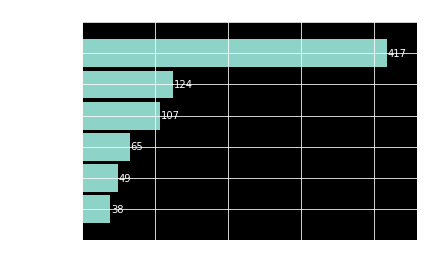

In [13]:
evals_result = {}  # to record eval results for plotting
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=400,
                valid_sets=[lgb_train, lgb_test],
                #feature_name=['f' + str(i + 1) for i in range(X_train.shape[-1])],
                #categorical_feature=["dayofweek"],
                evals_result=evals_result,
                verbose_eval=10)

_ = plot_importance(gbm, height=0.9)

## Predict

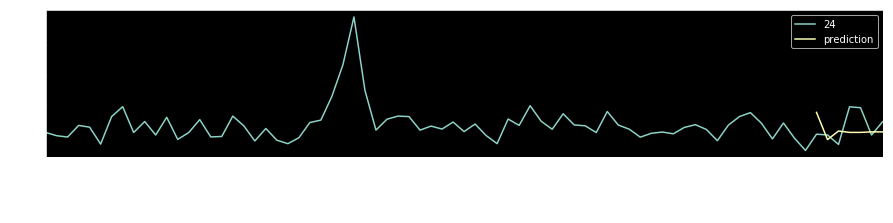

In [15]:
df_test['prediction'] = gbm.predict(X_test)
df_all = pd.concat([df_test, df_train], sort=False)
_ = df_all[[site,'prediction']].plot(figsize=(15, 3))

## Evaluation

## Evaluate All Sites

[10]	training's l1: 3374.27	training's l2: 3.32815e+07	valid_1's l1: 4649.22	valid_1's l2: 2.58609e+07
[20]	training's l1: 3337.75	training's l2: 3.13423e+07	valid_1's l1: 4667.94	valid_1's l2: 2.68522e+07
[30]	training's l1: 3341.21	training's l2: 3.02616e+07	valid_1's l1: 4692.3	valid_1's l2: 2.78352e+07
[40]	training's l1: 3336.71	training's l2: 2.9524e+07	valid_1's l1: 4739.66	valid_1's l2: 2.85948e+07
[50]	training's l1: 3329.88	training's l2: 2.9008e+07	valid_1's l1: 4745.78	valid_1's l2: 2.90002e+07
[60]	training's l1: 3339.83	training's l2: 2.86464e+07	valid_1's l1: 4771.13	valid_1's l2: 2.97147e+07
[70]	training's l1: 3349.47	training's l2: 2.83755e+07	valid_1's l1: 4750.12	valid_1's l2: 2.98909e+07
[80]	training's l1: 3352.79	training's l2: 2.81952e+07	valid_1's l1: 4734.24	valid_1's l2: 2.99775e+07
[90]	training's l1: 3359.6	training's l2: 2.80458e+07	valid_1's l1: 4745.34	valid_1's l2: 2.99516e+07
[100]	training's l1: 3362.05	training's l2: 2.79238e+07	valid_1's l1: 4754.7	

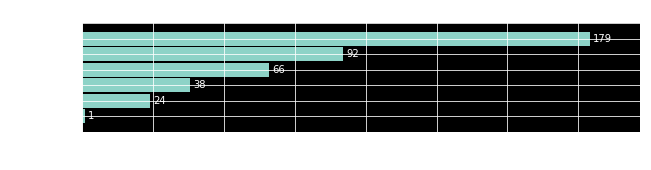

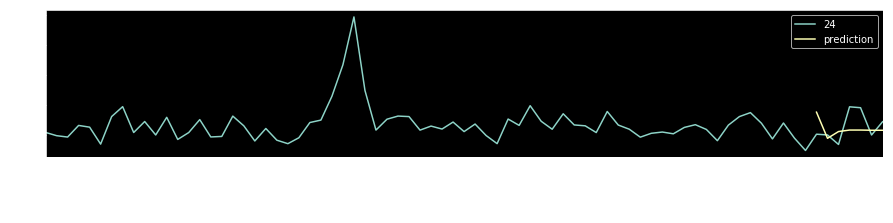

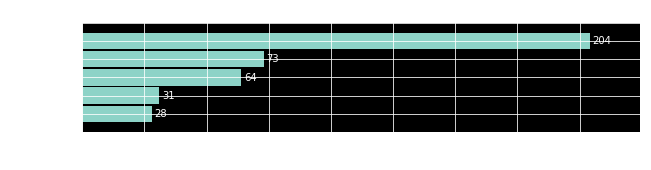

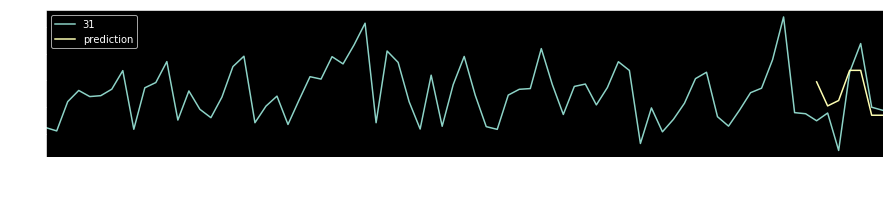

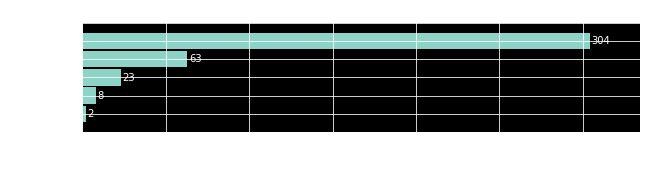

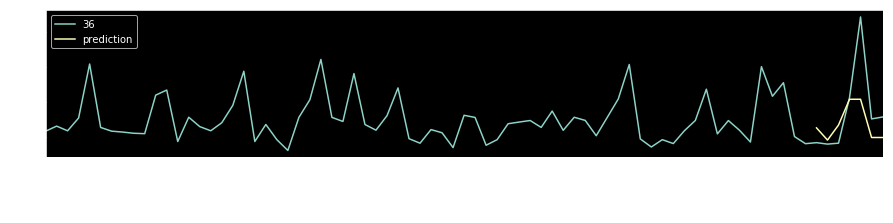

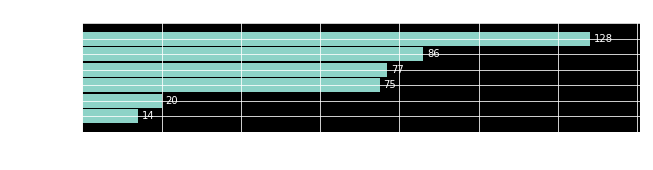

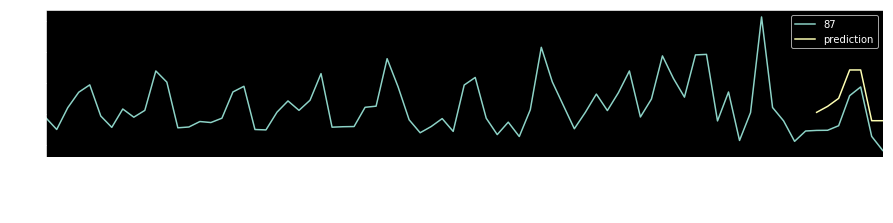

In [18]:
for i, site in enumerate(sample_sites):
    X_train, y_train = create_features(df_train, df_weather, label=site)
    X_test, y_test = create_features(df_test, df_weather, label=site)
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)
    
    evals_result = {}  # to record eval results for plotting
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=200,
                    valid_sets=[lgb_train, lgb_test],
                    #feature_name=['f' + str(i + 1) for i in range(X_train.shape[-1])],
                    #categorical_feature=["dayofweek"],
                    evals_result=evals_result,
                    verbose_eval=10)
    
    _ = plot_importance(gbm, height=0.9, figsize=(10, 2))
    
    df_test['prediction'] = gbm.predict(X_test)
    df_all = pd.concat([df_test, df_train], sort=False)
    _ = df_all[[site,'prediction']].plot(figsize=(15, 3))